# 3.5 The Image Classification Dataset

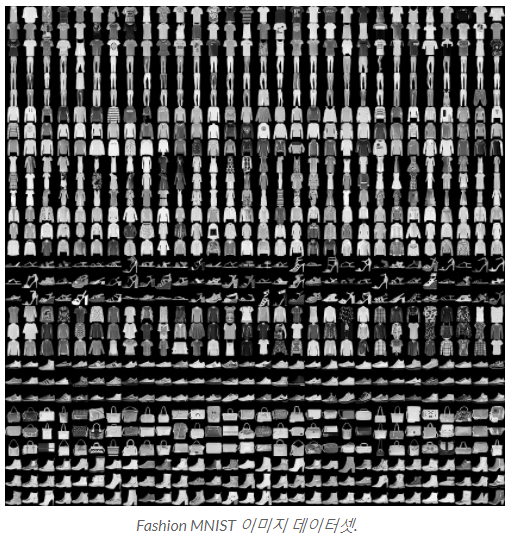

Fashion MNIST 데이터셋은 위 그림과 같이 운동화, 셔츠, 샌들과 같은 작은 이미지들의 모음이며, 기본 MNIST 데이터셋과 같이 열 가지로 분류될 수 있는 28×28 픽셀의 이미지 70,000개로 이루어져 있다.

In [37]:
!pip install d2l

## 3.5.1 Reading the Dataset

프레임 워크 내장 함수를 통해 Fashion-MNIST 데이터 셋을 다운 받아 메모리로 읽을 수 있다.

In [2]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

d2l.use_svg_display()

In [3]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
len(mnist_train[0]), len(mnist_test[0])

(60000, 10000)

In [5]:
mnist_train[0][0].shape

(28, 28)

각 입력 이미지의 높이와 너비는 모두 28 픽셀이다. 데이터 세트는 채널 수가 1 인 회색조 이미지로 구성되어 있다. 간결성을 위해이 책에서는 높이가있는 이미지의 모양을 저장한다. h  폭  w  픽셀  h×w  또는 ( h ,  w ).

Fashion-MNIST의 이미지는 티셔츠, 바지, 풀오버, 드레스, 코트, 샌들, 셔츠, 운동화, 가방 및 발목 부츠와 같은 카테고리와 관련이 있다. 다음 함수는 숫자 레이블 인덱스와 텍스트의 이름 사이를 변환한디.

In [6]:
def get_fashion_mnist_labels(labels):  
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

#### 시각화

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten() # 다차원 배열을 1차원으로 바꿔줌
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False) # 각 요소의 전체축을 숨기는 코드
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

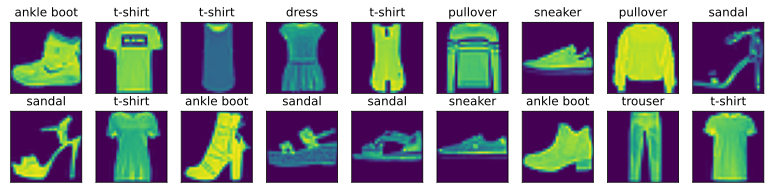

In [8]:
X = tf.constant(mnist_train[0][:18])
y = tf.constant(mnist_train[1][:18])
show_images(X, 2, 9, titles=get_fashion_mnist_labels(y));

## 3.5.2 Reading a Minibatch

In [9]:
batch_size = 256
train_iter = tf.data.Dataset.from_tensor_slices(mnist_train).batch(
    batch_size).shuffle(len(mnist_train[0]))

훈련 데이터를 읽는데 걸리는 시간 살펴보기

In [10]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'0.14 sec'

## 3.5.3 Putting All Things Together

이제 load_data_fashion_mnistFashion-MNIST 데이터 셋을 얻고 읽는 함수를 정의한다 . 훈련 세트와 검증 세트 모두에 대한 데이터 반복기를 반환한다. 또한 이미지 크기를 다른 모양으로 조정하는 선택적 인수를 허용한다.

In [11]:
def load_data_fashion_mnist(batch_size, resize=None): 
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    # expand_dims : axis로 지정된 차원추가
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32')) # 텐서의 새로운 형태 지정
    # image_resize_with_pad : 비를 동일하게 유지하여 이미지를 대상 폭과 높이로
    # 조정한다. 남은 부분은 0으로 채워진다.
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, resize, resize)
                              if resize else X, y)
    # tf.data.Dataset.from_tensor_slices : tf.data.Dataset를 생성하는 함수로
    # 입력된 텐서로부터 slices를 생성한다.
    return (tf.data.Dataset.from_tensor_slices(
        process(*mnist_train)).batch(batch_size).shuffle(len(
            mnist_train[0])).map(resize_fn), # .map : 여러 데이터를 한 번에 다른 형태로 변환
            tf.data.Dataset.from_tensor_slices(
                process(*mnist_test)).batch(batch_size).map(resize_fn))

아래 load_data_fashion_mnist에서는 resize 인수 를 지정하여 함수 의 이미지 크기 조정 기능을 테스트한다. 

In [12]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(32, 64, 64, 1) <dtype: 'float32'> (32,) <dtype: 'int32'>


## 3.5.4 Summary

Fashion-MNIST는 의류 분류 문제인데 10개의 카테고리를 고르는 문제이기는 함
위 사진을 높이가 H이고 밑이 W인 모양으로 저장을 한다.

## 3.6 Implementation of Softmax Regression from Scratch (스크래치..?에서 softmax regression 구현)

In [13]:
import tensorflow as tf
from IPython import display
from d2l import tensorflow as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 3.6.1. Initializing Model Parameters
(모델 파라미터 초기값 지정)

원시 데이터 세트의 각 예는 28×28 영상. 이 섹션에서는 각 이미지를 평면화하여 길이가 784 인 벡터로 취급한다. 

소프트 맥스 회귀에서는 클래스만큼 많은 출력이 있다. 데이터 세트에 10 개의 클래스가 있으므로 네트워크의 출력 차원은 10이다. 

결과적으로 가중치는  784×10  매트릭스와 편견은  1×10 행 벡터. 
선형 회귀와 마찬가지로 W가우시안 노이즈와 바이어스로 가중치 를 초기화 하여 초기 값 0을 취한다.

In [14]:
num_inputs = 784
num_outputs = 10

# tf.random.normal : 랜덤 정규분포 생성
W = tf.Variable(
    tf.random.normal(shape=(num_inputs, num_outputs), mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

## 3.6.2. Defining the Softmax Operation (활동)

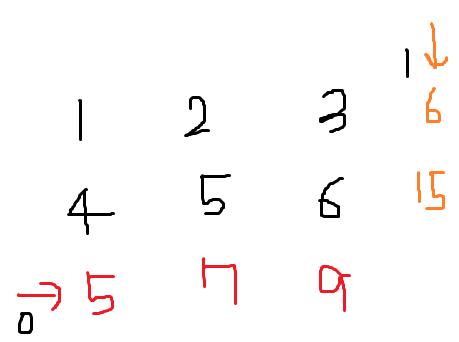

In [15]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

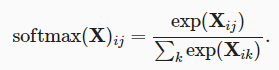

In [16]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

softmax 합계는 1이다.

In [17]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.1709013 , 0.24459724, 0.10053767, 0.24879508, 0.2351687 ],
        [0.1844963 , 0.13502178, 0.02391118, 0.08514949, 0.57142127]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)

## 3.6.3 Define Model

네트워크를 통해 입력이 출력에 매핑되는 방식을 정의한다. reshape 모델을 통해 데이터를 전달하기 전에 함수를 사용하여 배치의 각 원본 이미지를 벡터로 병합한다.

In [18]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

## 3.6.4 Define Loss Function

In [19]:
# 이해가 잘안돼영 !
# https://www.tensorflow.org/api_docs/python/tf/compat/v1/boolean_mask?hl=ko
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [20]:
def cross_entropy(y_hat, y):
    return -tf.math.log(
        tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

## 3.6.5. Classification Accuracy

예측이 라벨 클래스와 일치하면 y올바른 것이다. 분류 정확도는 올바른 모든 예측의 비율이다.

In [21]:
def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # 왜 1보다 커야 할까 ??
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

위의 예제를 바탕으로 나온 분류 정확도 비율은 다음과 같다.

In [22]:
accuracy(y_hat, y) / len(y)

0.5

모델의 정확도 평가

In [23]:
def evaluate_accuracy(net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), tf.size(y).numpy())
    return metric[0] / metric[1]

다음 Accumulator은 여러 변수에 대한 합계를 누적하는 유틸리티 클래스이다. 위의 evaluate_accuracy함수에서 우리는 Accumulator각각 정확한 예측 수와 예측 수를 모두 저장하기 위해 인스턴스에 2 개의 변수를 생성한다. 둘 다 데이터 세트를 반복하면서 시간이 지남에 따라 누적된다.

In [24]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [25]:
evaluate_accuracy(net, test_iter)

0.0744

## 3.6.6 Training

In [26]:
def train_epoch_ch3(net, train_iter, loss, updater): 
    """The training loop defined in Chapter 3."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape: # 자동미분
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):# 특정 데이터 타입 검사 함수
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables # 값을 변화시킬 것인지에 대한 인자
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [27]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [28]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [29]:
class Updater():  
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

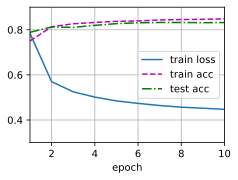

In [30]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 3.6.7 Prediction

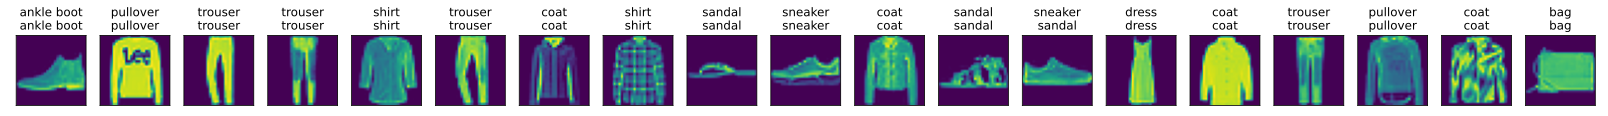

In [38]:
def predict_ch3(net, test_iter, n=19):
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 3.6.8. Summary

- softmax regression을 사용하여 다중 class 분류를 위한 모델을 훈련 가능하다.

## 3.7 Concise Implementation of Softmax Regression(간결한 구현)

In [32]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 3.7.1. Initializing Model Parameters

In [33]:
net = tf.keras.models.Sequential()
net.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
net.add(tf.keras.layers.Dense(10, kernel_initializer=weight_initializer))

## 3.7.2. Softmax Implementation Revisited (구현 재검토)

label이 정수일 때 사용한다.

In [39]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Optimization Algorithm

In [35]:
trainer = tf.keras.optimizers.SGD(learning_rate=.1)

## 3.7.4. Training

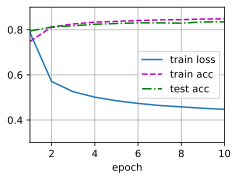

In [36]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)